In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pypfopt
import yfinance as yf

# Getting asset data using yfinance

In [182]:
tickers = ['0P0000Y2C1.IR', '0P0001KO9A.IR', 'SKIGLO.IR', 'SKIVEK.IR', '0P0001K6NJ.IR']
df = yf.download(tickers, start='2023-01-01')
df = df['Adj Close']
df = df.dropna()

[*********************100%%**********************]  5 of 5 completed


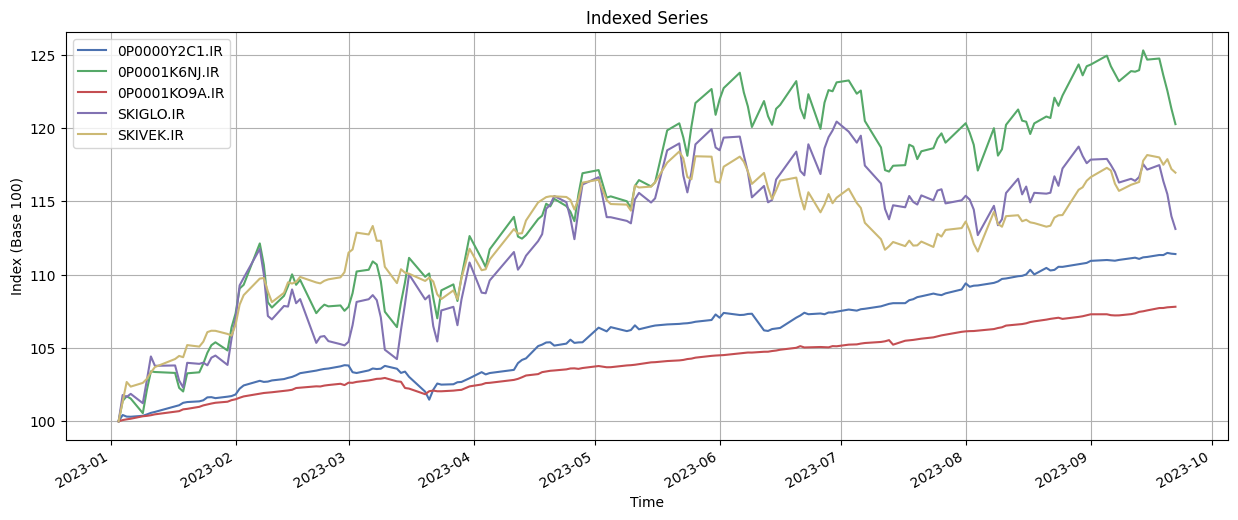

In [183]:
# Normalize each series to start at 100
normalized_df = df / df.iloc[0] * 100

# Plot
normalized_df.plot(figsize=(15,6))
plt.title("Indexed Series")
plt.ylabel("Index (Base 100)")
plt.xlabel("Time")
plt.grid(True)
plt.show()

# Covariance matrix

In [184]:
sigma = pypfopt.risk_models.risk_matrix(df,method='sample_cov',)
sigma.style.background_gradient(cmap='bwr')

,0P0000Y2C1.IR,0P0001K6NJ.IR,0P0001KO9A.IR,SKIGLO.IR,SKIVEK.IR
0P0000Y2C1.IR,0.001269,0.000006,0.000149,0.000143,0.000363
0P0001K6NJ.IR,0.000006,0.025685,0.000300,0.025426,0.013054
0P0001KO9A.IR,0.000149,0.000300,0.000169,0.000181,0.000357
SKIGLO.IR,0.000143,0.025426,0.000181,0.028411,0.012593
SKIVEK.IR,0.000363,0.013054,0.000357,0.012593,0.011302


In [185]:
sigmaL = pypfopt.risk_models.risk_matrix(df,method='ledoit_wolf')
sigmaL.style.background_gradient(cmap='bwr')

,0P0000Y2C1.IR,0P0001K6NJ.IR,0P0001KO9A.IR,SKIGLO.IR,SKIVEK.IR
0P0000Y2C1.IR,0.001468,0.000006,0.000146,0.000139,0.000354
0P0001K6NJ.IR,0.000006,0.025318,0.000293,0.024837,0.012752
0P0001KO9A.IR,0.000146,0.000293,0.000393,0.000177,0.000349
SKIGLO.IR,0.000139,0.024837,0.000177,0.027981,0.012302
SKIVEK.IR,0.000354,0.012752,0.000349,0.012302,0.011269


## Correlation matrices

In [186]:
print('Sample Covariance')
pypfopt.risk_models.cov_to_corr(sigma).style.background_gradient(cmap='bwr')

Sample Covariance


,0P0000Y2C1.IR,0P0001K6NJ.IR,0P0001KO9A.IR,SKIGLO.IR,SKIVEK.IR
0P0000Y2C1.IR,1.000000,0.001093,0.322863,0.023768,0.095787
0P0001K6NJ.IR,0.001093,1.000000,0.144012,0.941253,0.766205
0P0001KO9A.IR,0.322863,0.144012,1.000000,0.082779,0.258624
SKIGLO.IR,0.023768,0.941253,0.082779,1.000000,0.702799
SKIVEK.IR,0.095787,0.766205,0.258624,0.702799,1.000000


In [187]:
print('Ledoit-Wolf Covariance') # In the future I want to utalize shrinkage aswell.
pypfopt.risk_models.cov_to_corr(sigmaL).style.background_gradient(cmap='bwr')

Ledoit-Wolf Covariance


,0P0000Y2C1.IR,0P0001K6NJ.IR,0P0001KO9A.IR,SKIGLO.IR,SKIVEK.IR
0P0000Y2C1.IR,1.000000,0.001000,0.191953,0.021749,0.087114
0P0001K6NJ.IR,0.001000,1.000000,0.092763,0.933155,0.754957
0P0001KO9A.IR,0.191953,0.092763,1.000000,0.053344,0.165639
SKIGLO.IR,0.021749,0.933155,0.053344,1.000000,0.692782
SKIVEK.IR,0.087114,0.754957,0.165639,0.692782,1.000000


# Expected return

In general it is a bad idea to use historic returns to indicate future returns, but it's so much more work though...

In [188]:
# takes in the expected returns over a given period and returns the annualized returns
def annualize_returns(returns, periods_in_year):
    """
    Calculate the annualized returns based on the given returns over a certain period.
    
    Parameters:
    - returns (float): The expected returns over a given period.
    - periods_in_year (int): The number of periods in one year (e.g., 12 for monthly).
    
    Returns:
    - float: Annualized returns.
    """
    
    return (1 + returns)**(periods_in_year) - 1

def tdist_MLE(y,v, plot = False, name = None): # Should probably use multivariate distribution...
    mu0 = None
    sigma20 = None
    mu = 1
    sigma2 = 1
    w = np.array([i/y.shape[0] for i in range(y.shape[0])])
    
    while mu0 != mu and sigma20 != sigma2:
        mu0 = mu
        sigma20 = sigma2
    
        mu = np.sum(w*y)/np.sum(w)

        sigma2 = np.sum(w*(y-mu)**2)/len(y)

        w = ((v + 1) * sigma2)/(v*sigma2+(y-mu)**2)
    if plot:    
        y.hist()
        plt.axvline(mu, c='r')
        plt.axvline(mu+np.sqrt(sigma2), c='orange')    
        plt.axvline(mu-np.sqrt(sigma2), c='orange')
        plt.title(name)    
        plt.show()
    return mu, sigma2, w


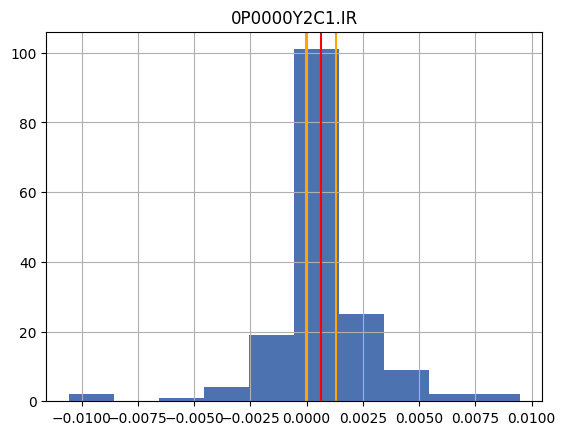

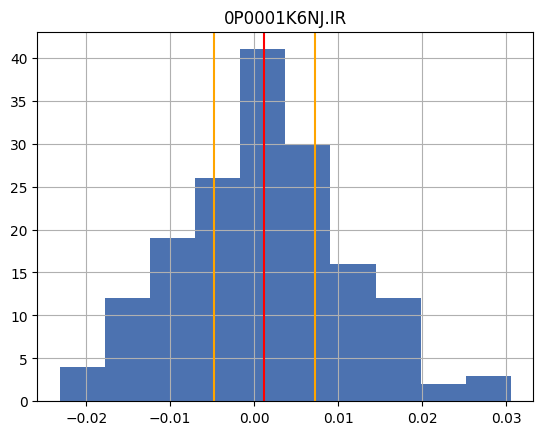

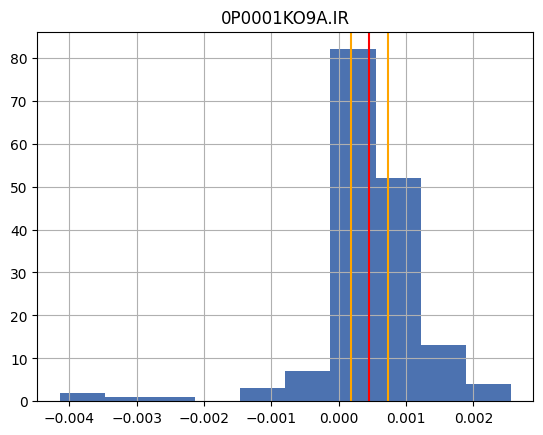

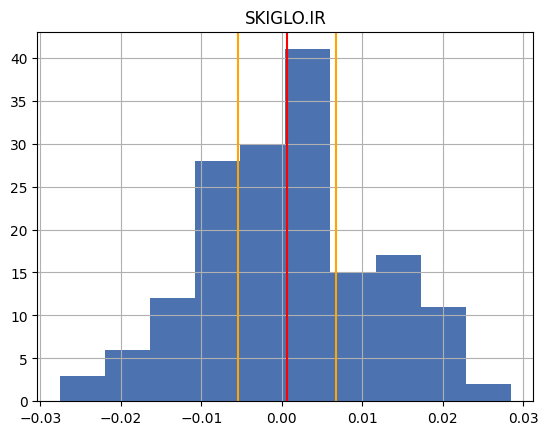

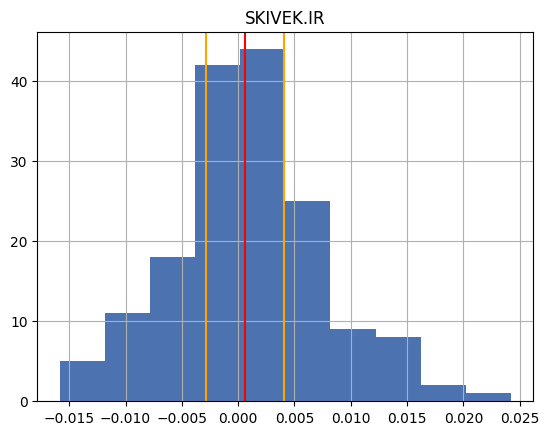

In [189]:
daily_returns = (df/df.shift(1)) - 1
er = {}
for i in daily_returns.columns:
    er[i] = tdist_MLE(daily_returns[i],1, True, name=i)[0]
er = pd.Series([i[1] for i in er.items()], index=er.keys())
annual_return =  annualize_returns(er, 250)

In [190]:
annual_return_simple =  annualize_returns(daily_returns.mean(), 252)
print('Simple mean annualized returns')
annual_return_simple

Simple mean annualized returns


0P0000Y2C1.IR    0.180094
0P0001K6NJ.IR    0.342519
0P0001KO9A.IR    0.121829
SKIGLO.IR        0.224258
SKIVEK.IR        0.277381
dtype: float64

In [191]:
annual_return =  annualize_returns(er, 252)
rf = 0.04
print('Cauchy MLE annualized returns') # A lot more robust to outliers. Suitable for small samples like here (1 year).
annual_return

Cauchy MLE annualized returns


0P0000Y2C1.IR    0.174613
0P0001K6NJ.IR    0.352697
0P0001KO9A.IR    0.120507
SKIGLO.IR        0.167216
SKIVEK.IR        0.166636
dtype: float64

# efficient frontier

In [192]:
# This one is shit. Only show it to illustrate how shit it is.
ef=pypfopt.efficient_frontier.EfficientFrontier(annual_return, sigma, weight_bounds=(0, 1), solver=None, verbose=False, solver_options=None)
ef.max_sharpe(rf)
print('Max Sharpe using Cauchy and SCOV')
ef.portfolio_performance(rf)
ef.clean_weights()

Max Sharpe using Cauchy and SCOV
Expected annual return: 13.1%
Annual volatility: 1.4%
Sharpe Ratio: 6.58


/Users/williamsoma/miniconda3/envs/jobb/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


OrderedDict([('0P0000Y2C1.IR', 0.11996),
             ('0P0001K6NJ.IR', 0.01534),
             ('0P0001KO9A.IR', 0.86471),
             ('SKIGLO.IR', 0.0),
             ('SKIVEK.IR', 0.0)])

In [193]:
# This one is still shit, but less so.
efL=pypfopt.efficient_frontier.EfficientFrontier(annual_return, sigmaL, weight_bounds=(0, 1), solver=None, verbose=False, solver_options=None)
efL.max_sharpe(risk_free_rate=rf)
print('Max Sharpe using Cauchy and Ledoit-Wolf')
efL.portfolio_performance(rf)
efL.clean_weights()

Max Sharpe using Cauchy and Ledoit-Wolf
Expected annual return: 14.6%
Annual volatility: 2.0%
Sharpe Ratio: 5.19


OrderedDict([('0P0000Y2C1.IR', 0.29419),
             ('0P0001K6NJ.IR', 0.04079),
             ('0P0001KO9A.IR', 0.66502),
             ('SKIGLO.IR', 0.0),
             ('SKIVEK.IR', 0.0)])

# Adding turnover constraint

In [195]:
import cvxpy as cp

# current weight
# w_0 = [('0P0000Y2C1.IR', 0.1682),
#              ('0P0001K6NJ.IR', 0.1682),
#              ('0P0001KO9A.IR', 0.0561),
#              ('SKIGLO.IR', 0.2997),
#              ('SKIVEK.IR', 0.1682)]

w_0 = np.array([0.1682, 0.1682, 0.0561, 0.2997, 0.1682]) # Inital asset allocation
turnover = np.array([0.2, 0.2, 0.2, 0.2, 0.2]) # Cannot change the weight of any asset by more than percentage points
# turnover = np.array([1, 1, 1, 1, 1])

efL_c=pypfopt.efficient_frontier.EfficientFrontier(annual_return, sigmaL, weight_bounds=(0, 1), solver=None, verbose=False, solver_options=None)
efL_c.add_constraint(lambda x: cp.abs(x - w_0) <= turnover)

# efL_c.add_constraint(lambda x: x[3] >= w_0[3])
# efL_c.add_constraint(lambda x: x[4] >= w_0[4])

efL_c.max_sharpe(risk_free_rate=rf)
print('Max Sharpe using Cauchy, Ledoit-Wolf and turnover constraint')
efL_c.portfolio_performance(rf)
efL_c.clean_weights()

Max Sharpe using Cauchy, Ledoit-Wolf and turnover constraint
Expected annual return: 20.1%
Annual volatility: 7.5%
Sharpe Ratio: 2.15


OrderedDict([('0P0000Y2C1.IR', 0.2271),
             ('0P0001K6NJ.IR', 0.22709),
             ('0P0001KO9A.IR', 0.20905),
             ('SKIGLO.IR', 0.10966),
             ('SKIVEK.IR', 0.2271)])

# Plotting Efficient frontier

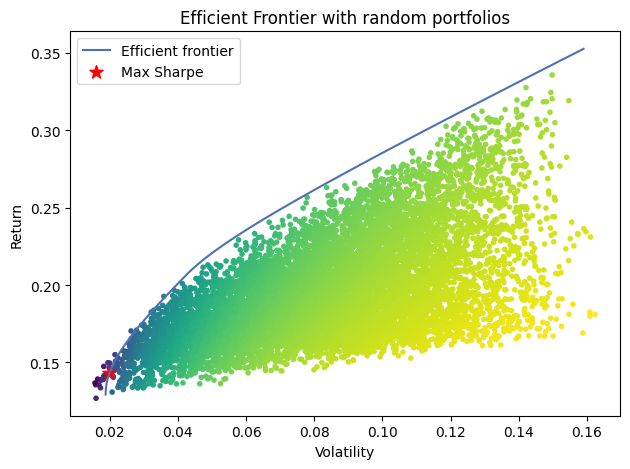

In [196]:
from pypfopt import plotting

efL=pypfopt.efficient_frontier.EfficientFrontier(annual_return, sigmaL, weight_bounds=(0, 1), solver=None, verbose=False, solver_options=None)
# efL_c.add_constraint(lambda x: cp.abs(x - w_0) <= turnover)

fig, ax = plt.subplots()
ef_max_sharpe = efL.deepcopy()
plotting.plot_efficient_frontier(efL, ax=ax, show_assets=False)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()


# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

This is quite funny actually. Lets just say that its easy to be a genius in a bull market.